In [1]:
import requests
import re
from bs4 import BeautifulSoup

In [2]:
ROOT_URLS ='https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81/408485'

In [3]:
def download(url):
    headers = {
        'User-Agent':
            'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36'}
    response = requests.get(url, headers=headers)
    html = response.content
    content = html.decode('utf-8')
    return content

In [4]:
def get_subway_ursl(ROOT_URLS):
    ''' 获取所有的地铁线url'''
    content = download(ROOT_URLS)
    soup = BeautifulSoup(content,'html.parser',from_encoding='utf-8')
    links = soup.find('table').find_all('a',href=re.compile('/item/'))
    urls = ['https://baike.baidu.com'+link.get('href') for link in links]
    names = [link.string for link in links]
    url_dict = {}
    for url,name in zip(urls,names):
        if name not in url_dict:
            url_dict[name]= url
    return url_dict

In [5]:
url_dict = get_subway_ursl(ROOT_URLS)

C:\Users\hc\Anaconda3\envs\tensor\lib\site-packages\bs4\__init__.py:179: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


In [6]:
url_dict

{'北京地铁1号线': 'https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%811%E5%8F%B7%E7%BA%BF',
 '复八线': 'https://baike.baidu.com/item/%E5%A4%8D%E5%85%AB%E7%BA%BF',
 '北京地铁13号线': 'https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%8113%E5%8F%B7%E7%BA%BF',
 '北京地铁八通线': 'https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81%E5%85%AB%E9%80%9A%E7%BA%BF',
 '北京地铁5号线': 'https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%815%E5%8F%B7%E7%BA%BF',
 '北京地铁8号线': 'https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%818%E5%8F%B7%E7%BA%BF',
 '北京地铁10号线': 'https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%8110%E5%8F%B7%E7%BA%BF',
 '北京地铁机场线': 'https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81%E6%9C%BA%E5%9C%BA%E7%BA%BF',
 '北京地铁4号线': 'https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%814%E5%8F%B7%E7%BA%BF',
 '北京地铁15号线': 'https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%8115%E5%8F%B7%E7%BA%BF',
 '北京地铁昌平线'

### 发现复八线就是地铁一号线，遂删除

In [7]:
url_dict.pop('复八线')

'https://baike.baidu.com/item/%E5%A4%8D%E5%85%AB%E7%BA%BF'

In [201]:
def find_class(html):
    pattern = re.compile('<table log-set-param="table_view" width="\w+" class="\w+"')
    pat = pattern.findall(html)
    class_ = re.findall('class="(.*)"', pat[0])
    return class_
def subway_parser(html):
    '''直接有站点，距离表的html分析方法'''
    soup = BeautifulSoup(html, 'html.parser')
    class_ = find_class(html)
    tables = soup.find('table', class_="%s" % class_[0]).find_all('tr')
    # tables = soup.find('table',class_='thirteen').find_all('tr')
    subway_staton = []
    for table in tables[1:]:
        sub_nodes = table.contents
        station = [sub_node.string for sub_node in sub_nodes if sub_node.string != None]
        if station != []:
            subway_staton.append(station)
    # subway_staton = [station.append(sub_node.string) for table in tables[1:] for sub_node in table.contents]
    return subway_staton
def subway_parser2(html):
    '''parser1的个例'''
    soup = BeautifulSoup(html, 'html.parser')
    class_ = find_class(html)
    tables = soup.find('table', class_="%s" % class_[0]).find_all('tr')
    # tables = soup.find('table',class_='thirteen').find_all('tr')
    direction = []
    distance = []
    for table in tables[1:]:
        if table.th.string != None:
            nodes = table.th.string.split('——')
        else:
            nodes = table.div.string.split('——')
        for node in nodes:
            if node not in direction:
                direction.append(node)
        distance.append(transform(table.td.string))
    return direction, distance
def subway_parser3(content):
    '''无直接站点之间距离表的html分析方法'''
    soup = BeautifulSoup(content, 'html.parser')
    table = soup.find('table', attrs={'data-sort': re.compile("sortDisabled")})
    url_htmls = table.find_all('a', href=re.compile('/item/'))  # 所有的站点名称及url（包括其他噪音）
    sub_urls = ['https://baike.baidu.com' + url.get('href') for url in url_htmls]
    #station = get_station(sub_urls)
    station_html = table.find_all('tr')
    station = []
    for tr in station_html[1:]:
        state = tr.find('a')
        try:
            station.append(transform2(str(state.contents[0])))
        except:
            pass
    return station
def transform(string):
    '''距离米，千米转换方法'''
    if re.findall(('\d+\.\d+'), string) != []:
        value = re.findall(('\d+\.\d+'), string)[0]
        return int(float(value) * 1000)
    else:
        value = re.findall(('\d+'), string)[0]
        if len(value) < 2:
            return int(value) * 1000
        else:
            return int(value)
def transform2(string):
    '''某些个例分析转换成标准表示的方法'''
    t = re.findall('<i>(.*)</i>',string)
    if re.findall('<i>(.*)</i>',string) != []:
        #print(re.findall('<i>(.*)</i>',string))
        return re.findall('<i>(.*)</i>',string)[0]
    else:
        return re.findall('\w+',string)[0]
def transform3(string):
    if string[-1]=='站':
        return string
    else:
        return string+'站'
def get_station_imformation(datas):
    '''处理方法'''
    station = []
    distance = []
    for data in datas:
        states = []
        if len(data[0].split('——')) == 2:
            states = data[0].split('——')
        elif len(data[0].split('～')) == 2:
            states = data[0].split('～')
        else:
            states = data[0].split('~')
        for state in states:
            if state not in station:
                station.append(state)
        distance.append(transform(data[1]))
    return station, distance
    
def get_all_station(url_dict, subway_dict):
    for key in url_dict.keys():
        url = url_dict[key]
        print(url)
        subway_dict[key] = {}
        content = download(url)
        try:
            if key == '北京地铁9号线':#地铁9号线分析方法
                subway_dict[key]['station'] = subway_parser3(content)
                continue
            if key == '北京地铁16号线':#地铁16号线分析方法
                subway_imformation = []
                soup = BeautifulSoup(content, 'html.parser')
                table_tr = soup.find('table', width='577').find_all('tr')
                for tr in table_tr[1:]:
                    sub_nodes = tr.contents
                    subway_imformation.append([sub_node.string for sub_node in sub_nodes if sub_node.string != None])
                subway_dict[key]['station'], subway_dict[key]['distance'] = \
                    get_station_imformation(subway_imformation)
                continue
            subway_imformation = subway_parser(content)
            subway_dict[key]['station'], subway_dict[key]['distance'] = \
                get_station_imformation(subway_imformation)
            #print(subway_dict)
        except Exception as e:
            '''无距离表的url，使用parse3；'''
            print(e)
            print('{} is different'.format(key))
            if key == '北京地铁8号线':#不适parse1分析方法，采用parse2
                subway_dict[key]['station'], subway_dict[key]['distance'] = subway_parser2(content)
                continue
            subway_dict[key]['station'] = subway_parser3(content)

In [202]:
subway_dict = {}
get_all_station(url_dict,subway_dict)

https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%811%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%8113%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81%E5%85%AB%E9%80%9A%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%815%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%818%E5%8F%B7%E7%BA%BF
list index out of range
北京地铁8号线 is different
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%8110%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81%E6%9C%BA%E5%9C%BA%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%814%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%8115%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81%E6%98%8C%E5%B9%B3%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81%E5%A4%A7%E5%

In [203]:
subway_dict #含所有地铁线的站点，但某些地铁线无法爬取到站间距

{'北京地铁1号线': {'station': ['苹果园',
   '古城',
   '八角游乐园',
   '八宝山',
   '玉泉路',
   '五棵松',
   '万寿路',
   '公主坟',
   '军事博物馆',
   '木樨地',
   '南礼士路',
   '复兴门',
   '西单',
   '天安门西',
   '天安门东',
   '王府井',
   '东单',
   '建国门',
   '永安里',
   '国贸',
   '大望路',
   '四惠',
   '四惠东'],
  'distance': [2606,
   1921,
   1953,
   1479,
   1810,
   1778,
   1313,
   1172,
   1166,
   1291,
   424,
   1590,
   1217,
   925,
   852,
   774,
   1230,
   1377,
   790,
   1385,
   1673,
   1714]},
 '北京地铁13号线': {'station': ['西直门',
   '大钟寺',
   '知春路',
   '五道口',
   '上地',
   '西二旗',
   '龙泽',
   '回龙观',
   '霍营',
   '立水桥',
   '北苑',
   '望京西',
   '芍药居',
   '光熙门',
   '柳芳',
   '东直门'],
  'distance': [2839,
   1206,
   1829,
   4866,
   2538,
   3623,
   1423,
   2110,
   4785,
   2272,
   6722,
   2152,
   1110,
   1135,
   1769]},
 '北京地铁八通线': {'station': ['四惠',
   '四惠东',
   '高碑店',
   '传媒大学',
   '双桥',
   '管庄',
   '八里桥',
   '通州北苑',
   '果园',
   '九棵树',
   '梨园',
   '临河里',
   '土桥'],
  'distance': [1715,
   1375,
   2002,
   1894,
   1912,
   1

In [204]:
subway_dict['北京地铁房山线']

{'station': ['郭公庄',
  '大葆台',
  '稻田',
  '长阳',
  '篱笆房',
  '广阳城',
  '良乡大学城北',
  '良乡大学城',
  '良乡大学城西',
  '良乡南关',
  '苏庄',
  '阎村东'],
 'distance': [1405,
  6466,
  4041,
  2150,
  1474,
  2003,
  1188,
  1738,
  1332,
  1330,
  2300]}

In [207]:
#将地铁线字典转化为站点、距离字典
import copy
def sub_dict2state_dict(subway_dict):
    sub_dict = subway_dict
    state_dic = {}
    dis_dic = {}
    for key in sub_dict.keys():
        stations = sub_dict[key]['station']
        stations = [transform3(station) for station in stations]
        if sub_dict[key].get('distance') != None:
            distance = sub_dict[key]['distance']
        else:
            distance = len(stations) * [None]
        # padding
        stations.insert(0, None)
        stations.append(None)
        distance.insert(0, None)
        distance.append(None)

        # 地铁站节点以及距离节点
        for i, station in enumerate(stations[1:-1]):
            index = i + 1
            if station != None and station not in state_dic:
                state_dic[station] = [stations[j] for j in [index - 1, index + 1] if stations[j] != None]
                add_distance(stations, distance, index,dis_dic)
            else:
                for j in [index - 1, index + 1]:
                    if stations[j] != None:
                        state_dic[station].append(stations[j])
                        add_distance(stations, distance, index,dis_dic)
    return state_dic, dis_dic

def add_distance(station, distance, i, dis_dic):
    states = [station[i - 1], station[i + 1]]
    this_state = station[i]
    for state in states:
        if state != None:
            if this_state not in dis_dic:
                dis_dic[this_state] = {}
                dis_dic[this_state][state] = distance[i - 1]
            else:
                dis_dic[this_state][state] = distance[i - 1]
            i = i + 1
        else:
            i = i + 1
    return dict


In [208]:
station_dict , distance_dict = sub_dict2state_dict(subway_dict)

In [209]:
station_dict['阎村东站']

['苏庄站', '紫草坞站']

In [210]:
distance_dict

{'苹果园站': {'古城站': 2606, '金安桥站': None},
 '古城站': {'苹果园站': 2606, '八角游乐园站': 1921},
 '八角游乐园站': {'古城站': 1921, '八宝山站': 1953},
 '八宝山站': {'八角游乐园站': 1953, '玉泉路站': 1479},
 '玉泉路站': {'八宝山站': 1479, '五棵松站': 1810},
 '五棵松站': {'玉泉路站': 1810, '万寿路站': 1778},
 '万寿路站': {'五棵松站': 1778, '公主坟站': 1313},
 '公主坟站': {'万寿路站': 1313, '军事博物馆站': 1172, '莲花桥站': 1016, '西钓鱼台站': 2386},
 '军事博物馆站': {'公主坟站': 1172, '木樨地站': 1166, '北京西站': None, '白堆子站': None},
 '木樨地站': {'军事博物馆站': 1166, '南礼士路站': 1291},
 '南礼士路站': {'木樨地站': 1291, '复兴门站': 424},
 '复兴门站': {'南礼士路站': 424, '西单站': 1590},
 '西单站': {'复兴门站': 1590, '天安门西站': 1217, '灵境胡同站': 1011, '宣武门站': 815},
 '天安门西站': {'西单站': 1217, '天安门东站': 925},
 '天安门东站': {'天安门西站': 925, '王府井站': 852},
 '王府井站': {'天安门东站': 852, '东单站': 774},
 '东单站': {'王府井站': 774, '建国门站': 1230, '灯市口站': 945, '崇文门站': 821},
 '建国门站': {'东单站': 1230, '永安里站': 1377},
 '永安里站': {'建国门站': 1377, '国贸站': 790},
 '国贸站': {'永安里站': 790, '大望路站': 1385, '金台夕照站': 835, '双井站': 1759},
 '大望路站': {'国贸站': 1385, '四惠站': 1673},
 '四惠站': {'大望路站': 1673, '四惠东站': 1715},
 '四惠东站'

### 以上将所有车站信息处理完成

In [211]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

In [212]:
%matplotlib inline

In [213]:
station_graph = nx.Graph()

In [214]:
stations = list(station_dict.keys())

In [215]:
station_graph.add_nodes_from(stations)

In [216]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [217]:
station_connection_graph = nx.Graph(station_dict)

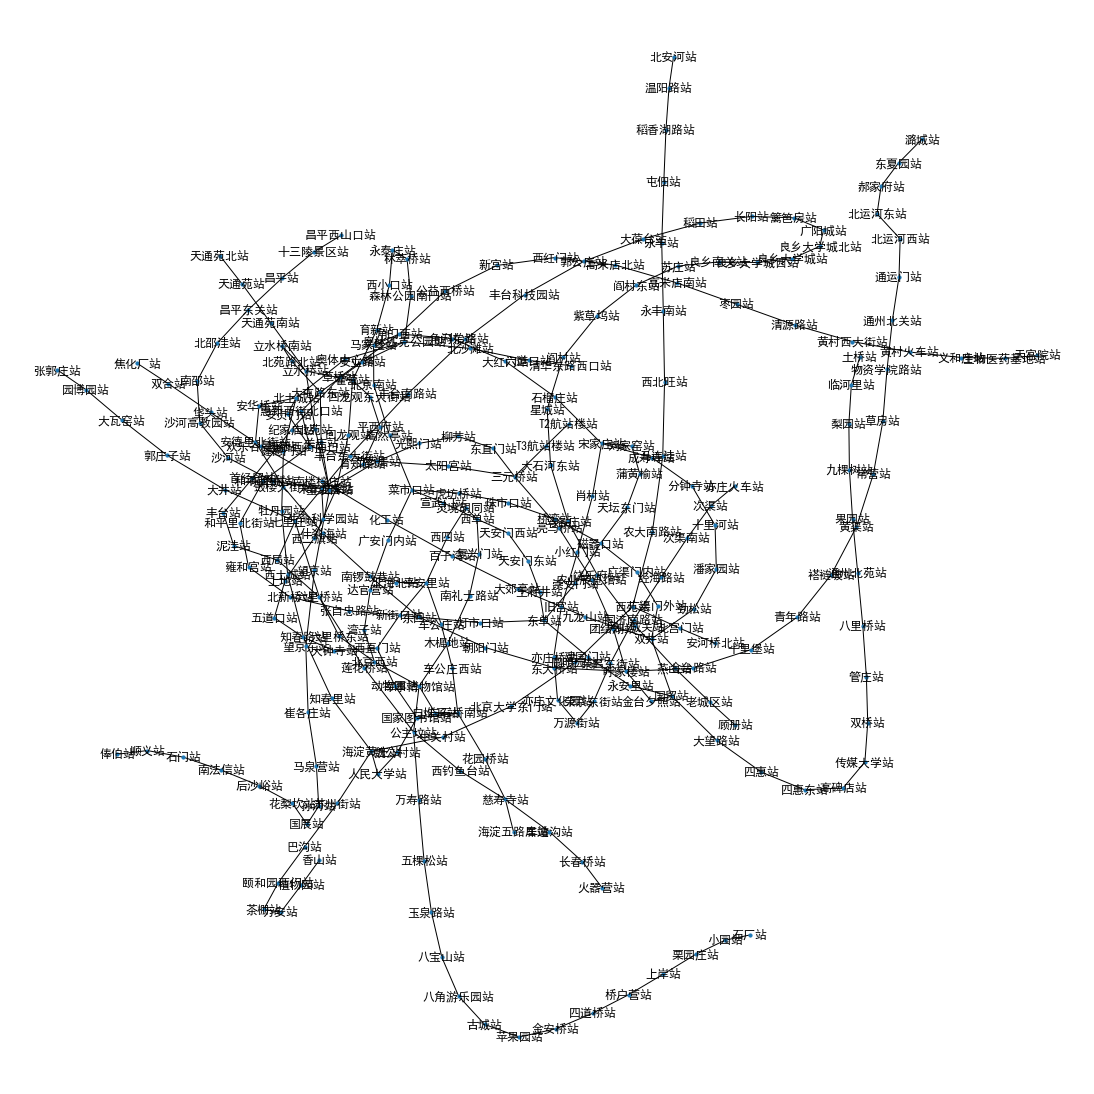

In [218]:
plt.figure(figsize=(15, 15))
nx.draw(station_connection_graph,with_labels=True,node_size = 10)
plt.savefig("graph.png", dpi=250)


In [191]:
plt.show()

defaultdict(list,
            {'苹果园': ['古城'],
             '古城': ['苹果园', '八角游乐园'],
             '八角游乐园': ['古城', '八宝山'],
             '八宝山': ['八角游乐园', '玉泉路'],
             '玉泉路': ['八宝山', '五棵松'],
             '五棵松': ['玉泉路', '万寿路'],
             '万寿路': ['五棵松', '公主坟'],
             '公主坟': ['万寿路', '军事博物馆', '莲花桥', '西钓鱼台'],
             '军事博物馆': ['公主坟', '木樨地'],
             '木樨地': ['军事博物馆', '南礼士路'],
             '南礼士路': ['木樨地', '复兴门'],
             '莲花桥': ['苹果园'],
             '西钓鱼台': ['复兴门'],
             '复兴门': ['万寿路', '玉泉路']})

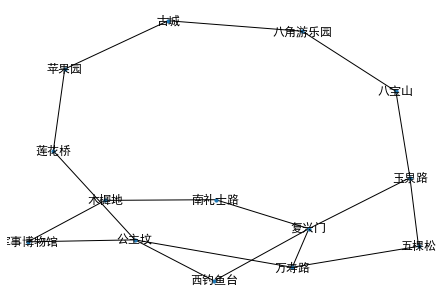